In [75]:
import pandas as pd
import numpy as np
import ast

from sklearn.metrics.pairwise import cosine_similarity

In [76]:
df = pd.read_csv("/content/data_frc_1787_to_1791_with_rev_year_dummy.csv")

In [77]:
df['openai_embedding'] = df['openai_embedding'].apply(lambda x: ast.literal_eval(x))

In [78]:
df_pred = pd.read_csv("/content/frc_1789_post_rev_predictions.csv")

In [79]:
df_pred['openai_embedding'] = df_pred['openai_embedding'].apply(lambda x: ast.literal_eval(x))

In [80]:
# Filter out content from 1789
df.drop(df[df['date'] == 1789].index, inplace=True)

In [81]:
df.date.unique()

array([1790, 1791, 1788, 1787])

In [82]:
df_pred['date'].unique()

array([1789])

In [83]:
# Separate the pre- and post-1789 embeddings for years 1787, 1788, 1790, 1791
pre_1789_emb = np.stack(df.loc[df['post_rev'] == 0, 'openai_embedding'].tolist())
post_1789_emb = np.stack(df.loc[df['post_rev'] == 1, 'openai_embedding'].tolist())

In [84]:
df_pred.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'topicmodel', 'call_number',
       'openai_embedding', 'post_rev', 'predicted_post_rev', 'new_pred_smote',
       'new_pred_wghtd', 'new_pred_us'],
      dtype='object')

In [85]:
# Separate the embeddings using pre- and post revolutionary text predictions
# Log reg predictions
pre_1789_emb_pred = np.stack(df_pred.loc[df_pred['predicted_post_rev'] == 0, 'openai_embedding'].tolist())
post_1789_emb_pred = np.stack(df_pred.loc[df_pred['predicted_post_rev'] == 1, 'openai_embedding'].tolist())

# SMOTE
pre_1789_emb_smote = np.stack(df_pred.loc[df_pred['new_pred_smote'] == 0, 'openai_embedding'].tolist())
post_1789_emb_smote = np.stack(df_pred.loc[df_pred['new_pred_smote'] == 1, 'openai_embedding'].tolist())

# Class weighted
pre_1789_emb_wghtd = np.stack(df_pred.loc[df_pred['new_pred_wghtd'] == 0, 'openai_embedding'].tolist())
post_1789_emb_wghtd = np.stack(df_pred.loc[df_pred['new_pred_wghtd'] == 1, 'openai_embedding'].tolist())

# Undersampled
pre_1789_emb_us = np.stack(df_pred.loc[df_pred['new_pred_us'] == 0, 'openai_embedding'].tolist())
post_1789_emb_us = np.stack(df_pred.loc[df_pred['new_pred_us'] == 1, 'openai_embedding'].tolist())


In [86]:
# Compute pre-revolution similarities for each prediction method

pre_similarities = {
    'Logistic Regression': cosine_similarity(pre_1789_emb, pre_1789_emb_pred).mean(),
    'SMOTE': cosine_similarity(pre_1789_emb, pre_1789_emb_smote).mean(),
    'Class Weighted': cosine_similarity(pre_1789_emb, pre_1789_emb_wghtd).mean(),
    'Undersampled': cosine_similarity(pre_1789_emb, pre_1789_emb_us).mean()
}

In [87]:
# Compute post-revolution similarities for each prediction method

post_similarities = {
    'Logistic Regression': cosine_similarity(post_1789_emb, post_1789_emb_pred).mean(),
    'SMOTE': cosine_similarity(post_1789_emb, post_1789_emb_smote).mean(),
    'Class Weighted': cosine_similarity(post_1789_emb, post_1789_emb_wghtd).mean(),
    'Undersampled': cosine_similarity(post_1789_emb, post_1789_emb_us).mean()
}

In [88]:
# Display the similarities
print("Pre-revolution similarities:")
for method, similarity in pre_similarities.items():
    print(f"{method}: {similarity}")

print("\nPost-revolution similarities:")
for method, similarity in post_similarities.items():
    print(f"{method}: {similarity}")

Pre-revolution similarities:
Logistic Regression: 0.6416738049136153
SMOTE: 0.6365482548386948
Class Weighted: 0.6331636362968855
Undersampled: 0.6340497964791083

Post-revolution similarities:
Logistic Regression: 0.5882577197773426
SMOTE: 0.581308233247828
Class Weighted: 0.5824732612477385
Undersampled: 0.5815879265766184


## Plotting pre- and post-revolution embedding similarities with pre- and post-classification of 1789 embeddings

### Heatmaps

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import random

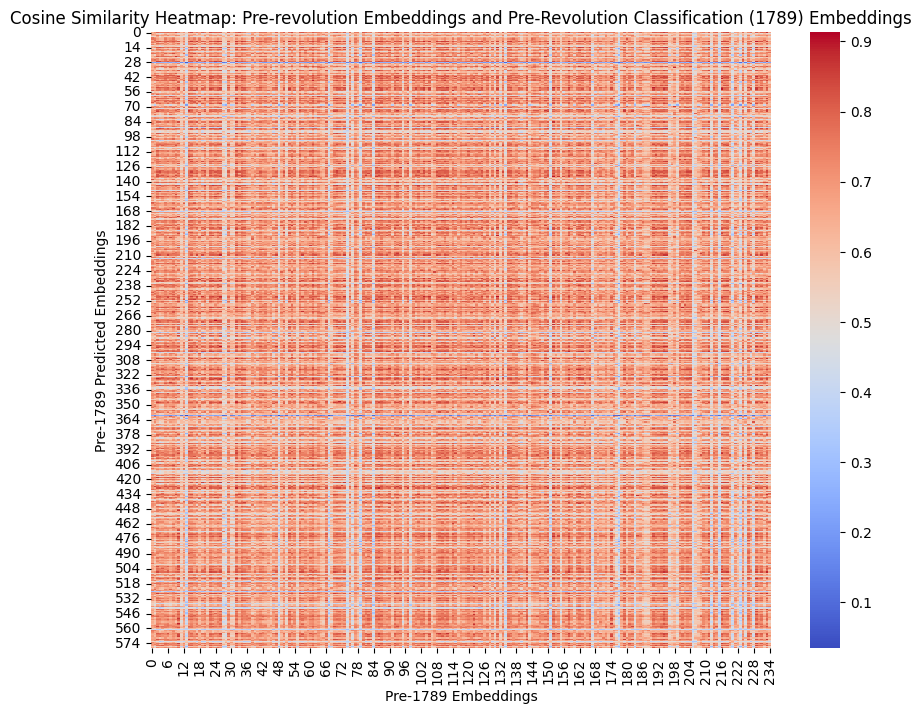

In [90]:
# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(pre_1789_emb, pre_1789_emb_pred)

# Plot heatmap of cosine similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, cmap='coolwarm', cbar=True)
plt.title('Cosine Similarity Heatmap: Pre-revolution Embeddings and Pre-Revolution Classification (1789) Embeddings')
plt.xlabel('Pre-1789 Embeddings')
plt.ylabel('Pre-1789 Predicted Embeddings')
plt.show()

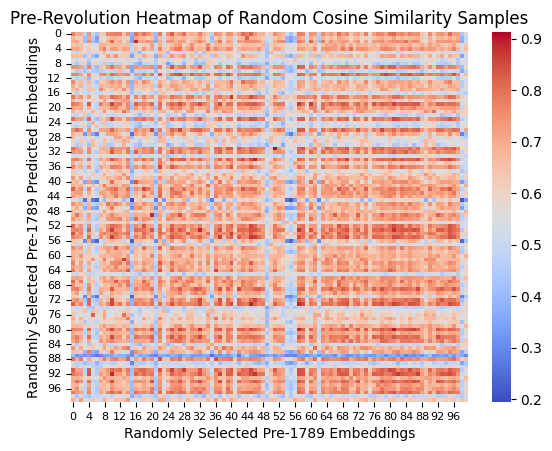

In [91]:
np.random.seed(43)
rows = np.random.choice(cosine_sim_matrix.shape[0], 100, replace=False)
cols = np.random.choice(cosine_sim_matrix.shape[1], 100, replace=False)
random_samples = cosine_sim_matrix[np.ix_(rows, cols)]

# Plot heatmap of the random samples

ax = sns.heatmap(random_samples, cmap='coolwarm', cbar=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.title('Pre-Revolution Heatmap of Random Cosine Similarity Samples')
plt.xlabel('Randomly Selected Pre-1789 Embeddings')
plt.ylabel('Randomly Selected Pre-1789 Predicted Embeddings')
plt.show()


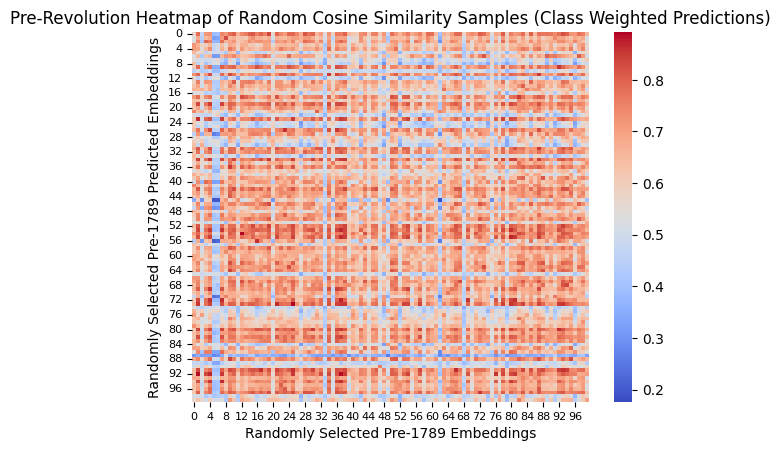

In [92]:
np.random.seed(43)

cosine_sim_matrix_wghtd = cosine_similarity(pre_1789_emb, pre_1789_emb_wghtd)

cols_wghtd = np.random.choice(cosine_sim_matrix_wghtd.shape[1], 100, replace=False)
random_samples_wghtd = cosine_sim_matrix_wghtd[np.ix_(rows, cols_wghtd)]

# Plot heatmap of the random samples

ax = sns.heatmap(random_samples_wghtd, cmap='coolwarm', cbar=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.title('Pre-Revolution Heatmap of Random Cosine Similarity Samples (Class Weighted Predictions)')
plt.xlabel('Randomly Selected Pre-1789 Embeddings')
plt.ylabel('Randomly Selected Pre-1789 Predicted Embeddings')
plt.show()


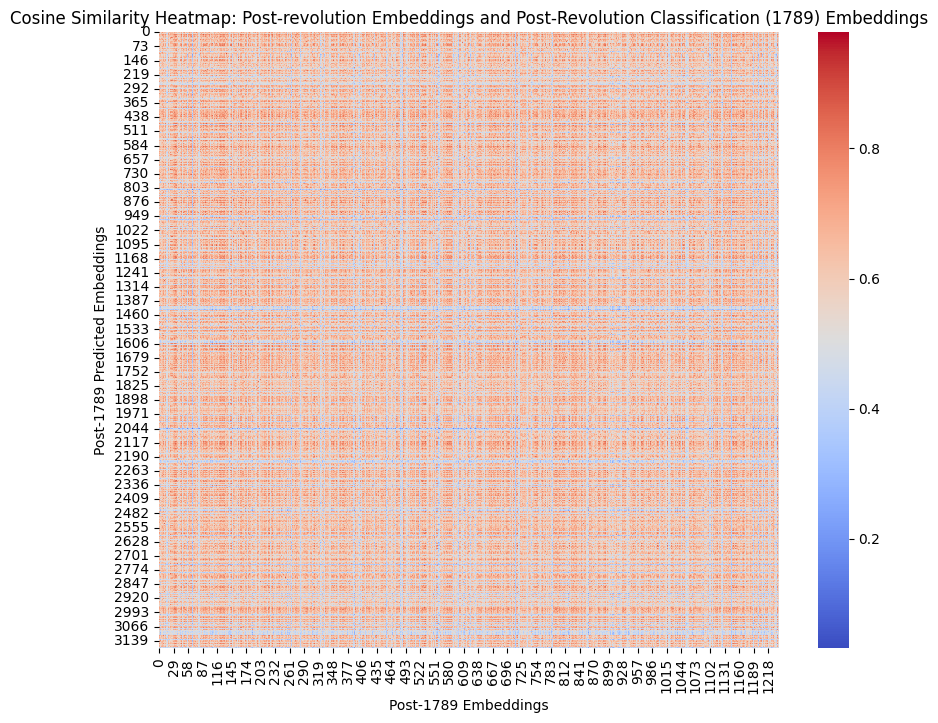

In [93]:
# Compute cosine similarity matrix
cosine_sim_matrix_post = cosine_similarity(post_1789_emb, post_1789_emb_pred)

# Plot heatmap of cosine similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_post, cmap='coolwarm', cbar=True)
plt.title('Cosine Similarity Heatmap: Post-revolution Embeddings and Post-Revolution Classification (1789) Embeddings')
plt.xlabel('Post-1789 Embeddings')
plt.ylabel('Post-1789 Predicted Embeddings')
plt.show()

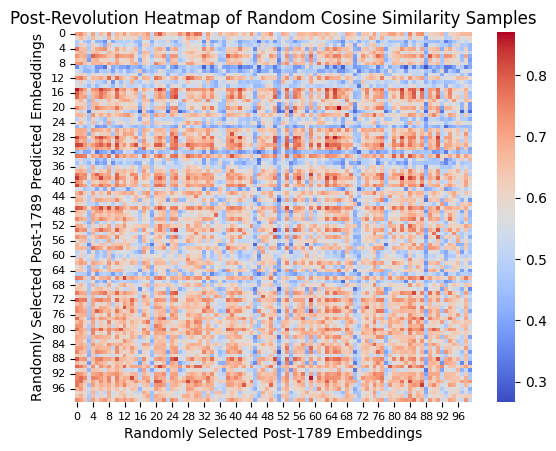

In [94]:
np.random.seed(43)
rows = np.random.choice(cosine_sim_matrix_post.shape[0], 100, replace=False)
cols = np.random.choice(cosine_sim_matrix_post.shape[1], 100, replace=False)
random_samples_post = cosine_sim_matrix_post[np.ix_(rows, cols)]

# Plot heatmap of the random samples
ax = sns.heatmap(random_samples_post, cmap='coolwarm', cbar=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.title('Post-Revolution Heatmap of Random Cosine Similarity Samples')
plt.xlabel('Randomly Selected Post-1789 Embeddings')
plt.ylabel('Randomly Selected Post-1789 Predicted Embeddings')
plt.show()


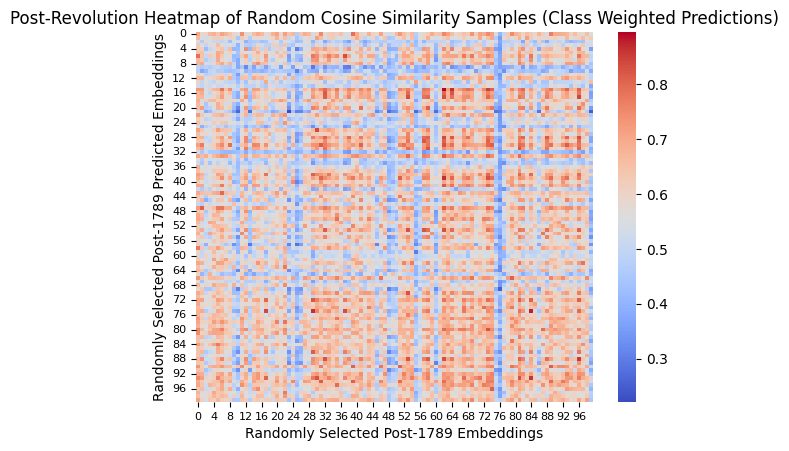

In [95]:
np.random.seed(43)

cosine_sim_post_wghtd = cosine_similarity(post_1789_emb, post_1789_emb_wghtd)

cols_wghtd = np.random.choice(cosine_sim_post_wghtd.shape[1], 100, replace=False)
random_samples_post_wghtd = cosine_sim_post_wghtd[np.ix_(rows, cols_wghtd)]

# Plot heatmap of the random samples

ax = sns.heatmap(random_samples_post_wghtd, cmap='coolwarm', cbar=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.title('Post-Revolution Heatmap of Random Cosine Similarity Samples (Class Weighted Predictions)')
plt.xlabel('Randomly Selected Post-1789 Embeddings')
plt.ylabel('Randomly Selected Post-1789 Predicted Embeddings')
plt.show()
